In [1]:
import os
import shutil

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam

# from dltk.io.augmentation import *


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
directory = "./lib/AD"
file_path = os.listdir(directory)[0]
img = nib.load(os.path.join(directory,file_path)).get_fdata()

# Modifications

# Randomly flip the image along axis 1
t1_flipped = flip(img.copy(), axis=1)
# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(img.copy(), sigma=20)

# Add Gaussian noise
t1_noise = add_gaussian_noise(img.copy(), sigma=25)
t1_trans_low_s = elastic_transform(img.copy(), alpha=[1, 1, 1], sigma=[50, 50, 50])
t1_trans_high_s = elastic_transform(img.copy(), alpha=[100, 2e5, 2e5], sigma=[100, 250, 250])


def show_2D(irm, slice, axe):
    if axe == "x":
        # plt.imshow(irm[slice,:,:], cmap="gray", vmin=0, vmax=255)
        plt.imshow(irm[slice,:,:], cmap="gray")

    elif axe == "y":
        # plt.imshow(irm[:,slice,:], cmap="gray", vmin=0, vmax=255)
        plt.imshow(irm[:,slice,:], cmap="gray")

    elif axe == "z":
        # plt.imshow(irm[:,:,slice], cmap="gray", vmin=0, vmax=255)
        plt.imshow(irm[:,:,slice], cmap="gray")

    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.colorbar()
    plt.show()

show_2D(img, 60, "x")
show_2D(t1_offset, 60, "x")
show_2D(t1_noise, 60, "x")
show_2D(t1_flipped, 60, "x")
show_2D(t1_trans_low_s, 60, "x")
show_2D(t1_trans_high_s, 60, "x")

show_2D(img, 60, "y")
show_2D(img, 60, "z")

NameError: name 'flip' is not defined

Data loading and preprocessing

In [2]:
# dirpath = "./data"
# if os.path.exists(dirpath) and os.path.isdir(dirpath):
#     shutil.rmtree(dirpath)

In [2]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset() 
print(data_dir)

Dataset arranged in ./data
./data


In [3]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

batch_size = 16
nb_classes = 4

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC", data_aug=False)
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC", data_aug=True)
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC")
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])


Train set size:  457
Validation set size:  115
Test set size:  146
Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Scan Visualization

228


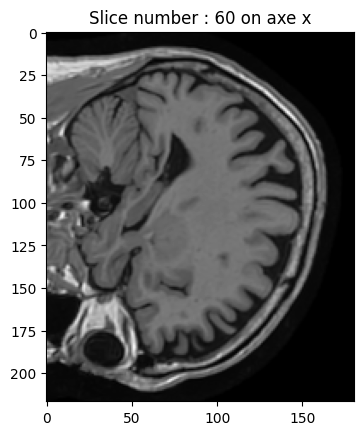

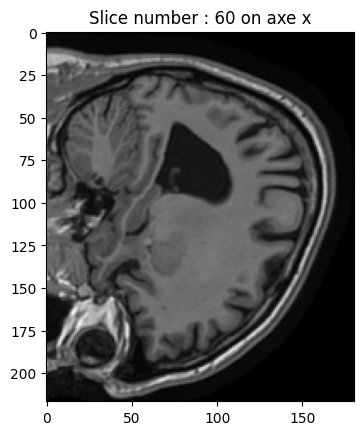

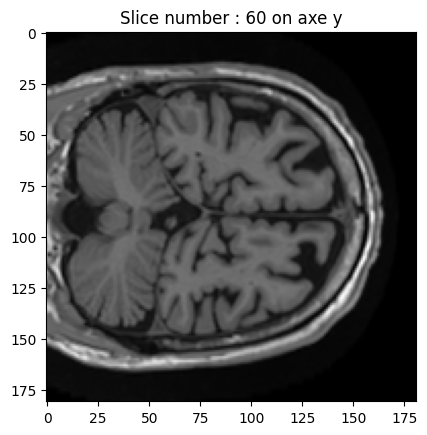

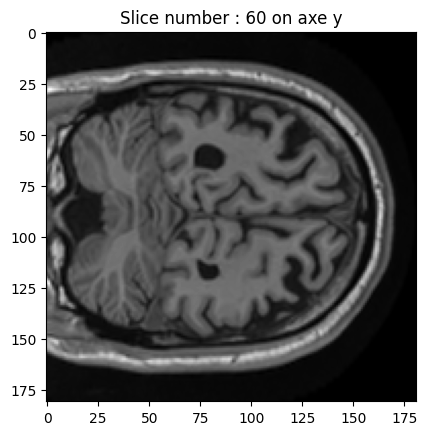

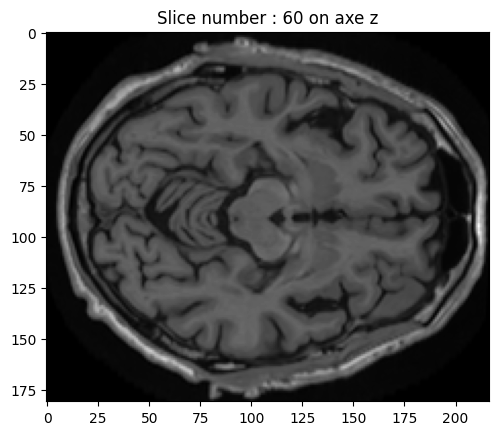

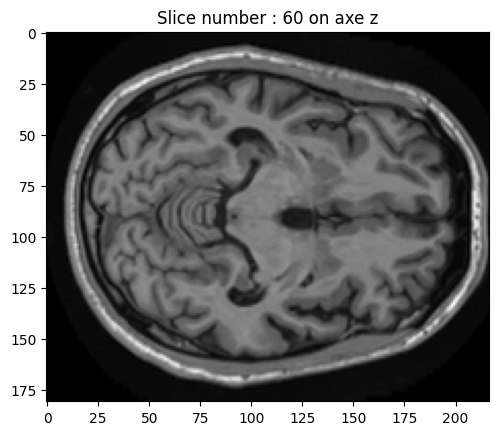

In [4]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()

firstAug = int(train_set.__len__()/2)
img = nib.load(train_set[0])
print(firstAug)
img2 = nib.load(train_set[firstAug])

show_2D(img.get_fdata(), 60, "x")
show_2D(img2.get_fdata(), 60, "x")

show_2D(img.get_fdata(), 60, "y")
show_2D(img2.get_fdata(), 60, "y")

show_2D(img.get_fdata(), 60, "z")
show_2D(img2.get_fdata(), 60, "z")

Imbalanced Data

{'AD': 191, 'CN': 227, 'PMCI': 171, 'SMCI': 129}


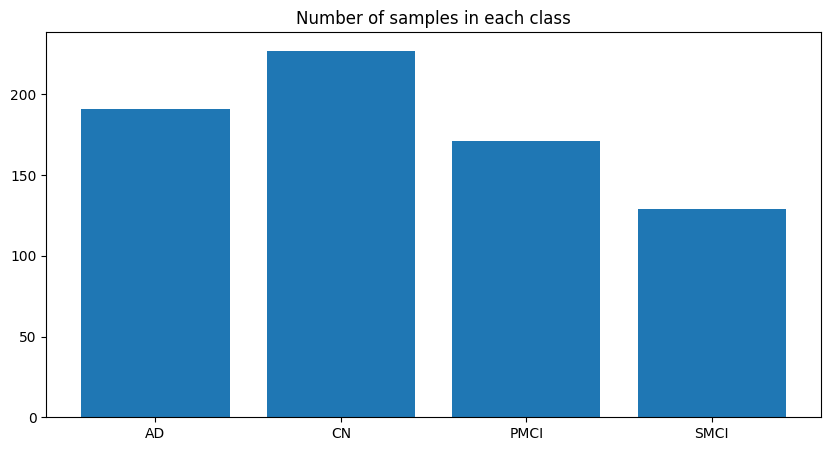

In [5]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["CN", "SMCI", "PMCI", "AD"]
if nb_classes == 2:
    class_names = ["CN", "AD"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

# 3D Convolutional Neural Network without data augmentation

In [6]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.2)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 80, 8)     32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                

/home/ybelkhedra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model training

In [7]:
# checkpoint
filepath="classifier3D_test_lol-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [8]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.2545 - accuracy: 0.4048
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to classifier3D_test_lol-01-0.50.hdf5
29/29 [==============================] - 79s 3s/step - loss: 1.2545 - accuracy: 0.4048 - val_loss: 1.2243 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10


/home/ybelkhedra/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.8184
Epoch 2: val_accuracy did not improve from 0.50000
29/29 [==============================] - 78s 3s/step - loss: 0.5890 - accuracy: 0.8184 - val_loss: 1.3602 - val_accuracy: 0.4554 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9803
Epoch 3: val_accuracy improved from 0.50000 to 0.51786, saving model to classifier3D_test_lol-03-0.52.hdf5
29/29 [==============================] - 75s 3s/step - loss: 0.1762 - accuracy: 0.9803 - val_loss: 1.4907 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.51786 to 0.55357, saving model to classifier3D_test_lol-04-0.55.hdf5
29/29 [==============================] - 77s 3s/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 1.4646 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 5/10
29/29 [====================

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


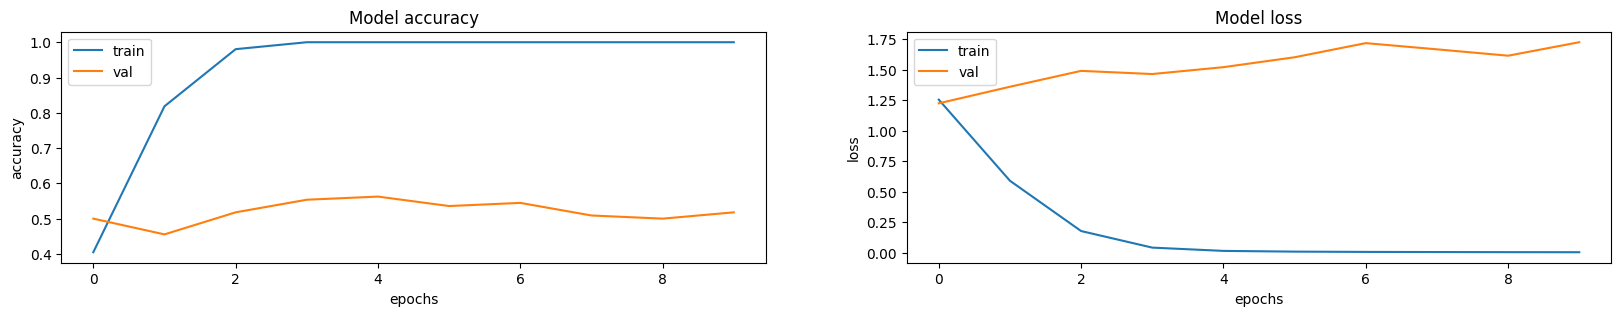

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [10]:
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 20s 2s/step - loss: 2.0969 - accuracy: 0.4384


[2.0969173908233643, 0.4383561611175537]

In [11]:
y = model.predict(test_sequence)

10/10 [==============================] - 20s 2s/step


In [13]:
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

[1 1 3 1 0 1 0 2 0 2 3 0 2 2 1 2 0 0 3 2 2 3 0 2 0 1 0 1 1 1 1 3 1 0 1 0 1
 0 1 2 2 2 1 1 0 2 2 3 1 0 1 2 0 3 0 0 2 1 0 1 0 0 0 0 3 0 3 1 1 1 0 2 0 3
 1 0 2 0 0 3 2 1 3 2 2 3 3 1 3 1 1 0 2 2 2 0 1 1 2 1 0 1 0 3 0 0 1 1 1 0 0
 0 3 1 1 1 0 0 0 0 0 2 1 0 3 2 3 1 0 1 0 3 2 2 2 2 0 2 0 1 0 3 2 0 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


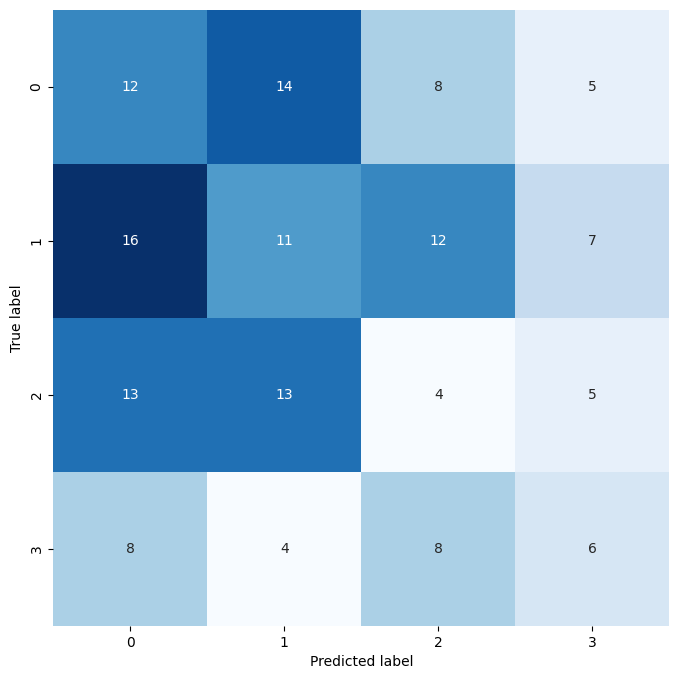

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Neural network with data augmentation

In [ ]:
input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.2)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'],
)

In [ ]:
# checkpoint
filepath="classifier3D_test-dataAug-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [ ]:
model.fit(
    train_sequence_aug,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])